In [1]:
%matplotlib inline
import os
import time
import warnings

from copy import deepcopy
from glob import glob
from PIL import Image
from PIL import ImageFile

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import functional as F

from scipy.ndimage import zoom
from torch.utils.data import DataLoader
from tqdm import tqdm


ImageFile.LOAD_TRUNCATED_IMAGES = True
warnings.filterwarnings('ignore')

In [2]:
def CAM(img, model, cuda=False):
    if cuda:
        img = img.cuda()
        model = model.cuda()
    
    # feature maps
    fm =  model(img)
    maps = fm.sum(dim=[-1, -2], keepdim=True)
    cam = (maps * fm).sum(1)
    return cam

In [23]:
def plot_cam(imgs, model, classes, cols=4, model_name='vgg16', use_cuda=False):
    if model_name == 'vgg16':
        features = model.features[:31]
    elif model_name == 'resnet50':
        features = torch.nn.Sequential(
            model.conv1,
            model.bn1,
            model.relu,
            model.maxpool,
            model.layer1,
            model.layer2,
            model.layer3,
            model.layer4,
        )
    elif model_name == 'densenet161':
        features = model.features[:31]
    
    cam = CAM(imgs.detach(), features, use_cuda)
    cam = cam.detach().cpu().numpy()
    
    # visualize images
    rows = len(imgs)//cols
    
    fig, axs = plt.subplots(3, 6,
#                             figsize=(16*(rows/cols), 14*(rows/cols)), 
                            figsize=(20, 11), 
                            squeeze=False)
    axs = axs.flatten()

    """
    We can get the original image back by reverting
    the normalization performed during preprocessing
    """
    for i, hm in enumerate(cam):
        _image = images[i].detach().numpy()
        _image = _image.transpose(1,2,0)
        _image = get_unnormalized_image(_image, std, mean)
        heatmap = zoom(hm, 32).astype(np.uint32)
        _max = heatmap.max()
        _min = heatmap.min()
        heatmap = np.abs((heatmap-_min)/(_max-_min))
        mask = (heatmap * 255).astype(np.uint8)
        _image = np.abs(_image)
        label = classes[labels[i]]
        axs[i].imshow(_image)
        axs[i].imshow(heatmap, cmap='jet', alpha=0.45)
        _ = axs[i].set_title(label)

In [4]:
def get_model_tranfer(model, num_classes, model_name='vgg16', use_cuda=False, freeze=False):
    model_transfer = deepcopy(model)
    
    # Freeze conv. layers to boost training and focus on 
    # the classifier, ie: fc layers
    if model_name == 'vgg16':
        for param in model_transfer.features[0:10]:
            param.requires_grad = (not freeze)
                
        # Get the number input features
        in_features = model.classifier[-1].in_features
        # Update classifier fully connected (fc) layer
        model_transfer.classifier[-1] = nn.Linear(in_features, num_classes)
    elif model_name == 'resnet50':
        for param in model_transfer.layer1:
            param.requires_grad = (not freeze)
        
        # Get the number input features
        in_features = model.fc.in_features
        # Update classifier fully connected (fc) layer
        model_transfer.fc = nn.Linear(in_features, num_classes)
    elif model_name == 'densenet161':
        for param in model_transfer.features[0:5].parameters():
            param.requires_grad = (not freeze)
        
        # Get the number input features
        in_features = model.classifier.in_features
        # Update classifier fully connected (fc) layer
        model_transfer.classifier = nn.Linear(in_features, num_classes)
    else:
        raise(Exception(f'Could not find {model_name} model.'))

    if use_cuda:
        model_transfer = model_transfer.cuda()
    
    return model_transfer

In [5]:
def get_unnormalized_image(image, std, mean):
    _image = image * std
    _image += mean
    _image = np.clip(_image, 0, 1)
    _image *= 255 # Bound to RGB values [0-255]
    _image = _image.astype(np.uint8)
    return _image

In [6]:
def train(n_epochs, loaders, model, optimizer, criterion, scheduler, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    start_time = time.time()
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            optimizer.zero_grad()
            
            # find the loss and update the model parameters accordingly
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            
            ## record the average training loss, using something like
            train_loss += ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
                        
            print('\rEpoch: %d, Training Loss: %0.6f | %d/%d | %0.2f s' % (
                epoch, train_loss, batch_idx+1, len(loaders['train'])+1, time.time()-start_time), 
                  flush=True, end='')     
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # update the average validation loss
            outputs = model(data)
            loss = criterion(outputs, target)
            
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))    
            print('\rEpoch: %d, Validation Loss: %0.6f | %d/%d | %0.4f s' % (
                epoch, valid_loss, batch_idx+1, len(loaders['valid'])+1, time.time()-start_time), 
                  flush=True, end='')
        
        # print training/validation statistics 
        print('\rEpoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}\t'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), save_path)
                
        scheduler.step()
        
    # Clean gpu device
    data = data.cpu()
    target = target.cpu()
    outputs = outputs.cpu()
    torch.cuda.empty_cache()    
    
    return model

In [7]:
def test(loaders, model, criterion, use_cuda):
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    
    top_5_correct = 0.
    top_10_correct = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        top_5 = torch.topk(output.data, k=5, dim=1)
        top_5 = top_5.indices.cpu().numpy()
        
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
        
        top_5_correct += np.sum(target.cpu().numpy()[:, None] == top_5)
        
        print('\rTest Loss: %0.6f | %d/%d' % (
                test_loss, batch_idx+1, len(loaders['test'])), 
                  flush=True, end='')
        
    # Clean gpu device
    data = data.cpu()
    target = target.cpu()
    output = output.cpu()
    torch.cuda.empty_cache()
            
    print('\rTest Loss: {:.6f}\n'.format(test_loss))
    print('Test Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    
    print('Top-5 Accuracy: %2d%% (%2d/%2d)' % (
        100. * top_5_correct / total, top_5_correct, total))

In [8]:
dataset_root = os.path.join('data', 'dataset')
train_dir = os.path.join(dataset_root, 'train')
valid_dir = os.path.join(dataset_root, 'valid')
test_dir = os.path.join(dataset_root, 'test')

image_size = 224
resize_size = int(image_size * 1.35)
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

batch_size = 20
num_workers = 4

affine_transforms = [
    transforms.RandomAffine(45, translate=(0.15, 0.15))]

# Instantiate torch loader and dataset
datasets_dict = {
    'train': torchvision.datasets.ImageFolder(
        train_dir, 
        transform=transforms.Compose([
            transforms.RandomApply(affine_transforms, p=0.50),
#             transforms.RandomRotation(degrees=45),
            transforms.RandomCrop(image_size, pad_if_needed=True),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)])),
    'test': torchvision.datasets.ImageFolder(
        test_dir, 
        transform=transforms.Compose([
            transforms.Resize(resize_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)])),
    'valid': torchvision.datasets.ImageFolder(
        valid_dir, 
        transform=transforms.Compose([
            transforms.Resize(resize_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)]))
}

loaders_dict = {
    'train': DataLoader(
        datasets_dict['train'], batch_size=batch_size,
        shuffle=True, num_workers=num_workers),
    'test': DataLoader(
        datasets_dict['test'], batch_size=batch_size,
        shuffle=True, num_workers=num_workers),
    'valid': DataLoader(
        datasets_dict['valid'], batch_size=batch_size,
        shuffle=True, num_workers=num_workers)

}

In [9]:
datasets_dict['train'].classes

['car', 'cat', 'dog', 'house', 'tulip']

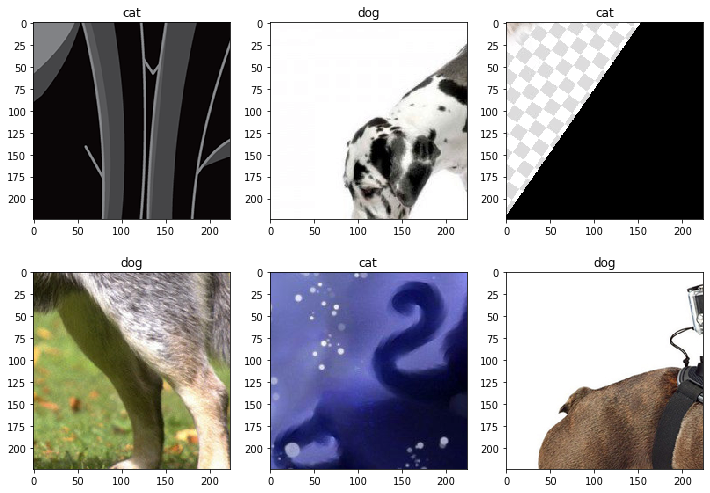

In [10]:
# Sanity check
images, labels = next(iter(loaders_dict['train']))

fig = plt.figure(figsize=(12, 13))
for i in range(6):
    class_name = datasets_dict['train'].classes[labels[i]]
    image = np.transpose(images[i].numpy(), axes=(1,2,0))
    # un-normalize
    image *= std
    image += mean
    image = np.clip(image, 0, 256)

    ax = fig.add_subplot(3, 3, i+1)
    ax.set_title(class_name, fontdict={'fontsize': 'large'})
    ax.imshow(image)
    
plt.show()

In [11]:
num_classes = len(datasets_dict['train'].classes)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# Download pre-trained models and update 
# fully connected layer with the new classes
# RESNET50 = models.resnet50(pretrained=True)
# resnet_transfer = get_model_tranfer(RESNET50, num_classes, 
#                                     'resnet50', use_cuda, 
#                                     freeze=True)

DENSENET161 = models.densenet161(pretrained=True)
densenet_transfer = get_model_tranfer(DENSENET161, num_classes, 
                                      'densenet161', use_cuda, 
                                      freeze=True)

# VGG16 = models.vgg16(pretrained=True)
# vgg_transfer = get_model_tranfer(VGG16, num_classes, 
#                                  'vgg16', use_cuda,
#                                  freeze=True)

In [12]:
# print('ResNet50:', resnet_transfer.fc)
# print('-' * 65) 
# print('VGG16:', vgg_transfer.classifier)
# print('-' * 65) 
print('DenseNet161:', densenet_transfer.classifier)

DenseNet161: Linear(in_features=2208, out_features=5, bias=True)


## Train DenseNet161

In [13]:
criterion_dense = nn.CrossEntropyLoss()
optimizer_dense = torch.optim.SGD(densenet_transfer.classifier.parameters(), 
                                lr=0.001, momentum=0.9)
scheduler_dense = torch.optim.lr_scheduler.StepLR(optimizer_dense, 40,
                                                  gamma=0.1, last_epoch=-1)

In [15]:
# train the model
path = os.path.join('models', 'model_densenet.pt')

model_scratch = train(40, loaders_dict, densenet_transfer, optimizer_dense, 
                      criterion_dense, scheduler_dense, use_cuda, 
                      path)

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load(path))

Epoch: 1 	Training Loss: 0.558880 	Validation Loss: 0.084923	
Epoch: 2 	Training Loss: 0.305091 	Validation Loss: 0.045182	
Epoch: 3 	Training Loss: 0.278136 	Validation Loss: 0.038765	
Epoch: 4 	Training Loss: 0.260252 	Validation Loss: 0.030048	
Epoch: 5 	Training Loss: 0.245776 	Validation Loss: 0.028959	
Epoch: 6 	Training Loss: 0.237809 	Validation Loss: 0.028694	
Epoch: 7 	Training Loss: 0.229554 	Validation Loss: 0.025499	
Epoch: 8 	Training Loss: 0.237020 	Validation Loss: 0.022186	
Epoch: 9 	Training Loss: 0.240716 	Validation Loss: 0.023225	
Epoch: 10 	Training Loss: 0.215651 	Validation Loss: 0.020757	
Epoch: 11 	Training Loss: 0.219778 	Validation Loss: 0.021479	
Epoch: 12 	Training Loss: 0.235279 	Validation Loss: 0.021572	
Epoch: 13 	Training Loss: 0.224780 	Validation Loss: 0.019498	
Epoch: 14 	Training Loss: 0.219933 	Validation Loss: 0.017828	
Epoch: 15 	Training Loss: 0.216759 	Validation Loss: 0.029441	
Epoch: 16 	Training Loss: 0.197688 	Validation Loss: 0.017715	
E

<All keys matched successfully>

In [16]:
# call test function
path = os.path.join('models', 'model_densenet.pt')

model_scratch = densenet_transfer
model_scratch.load_state_dict(torch.load(path))

test(loaders_dict, model_scratch, criterion_dense, use_cuda)

Test Loss: 0.021933 | 47/47

Test Accuracy: 99% (919/924)
Top-5 Accuracy: 100% (924/924)


## Plot CAMs

In [13]:
images, labels = next(iter(loaders_dict['test']))

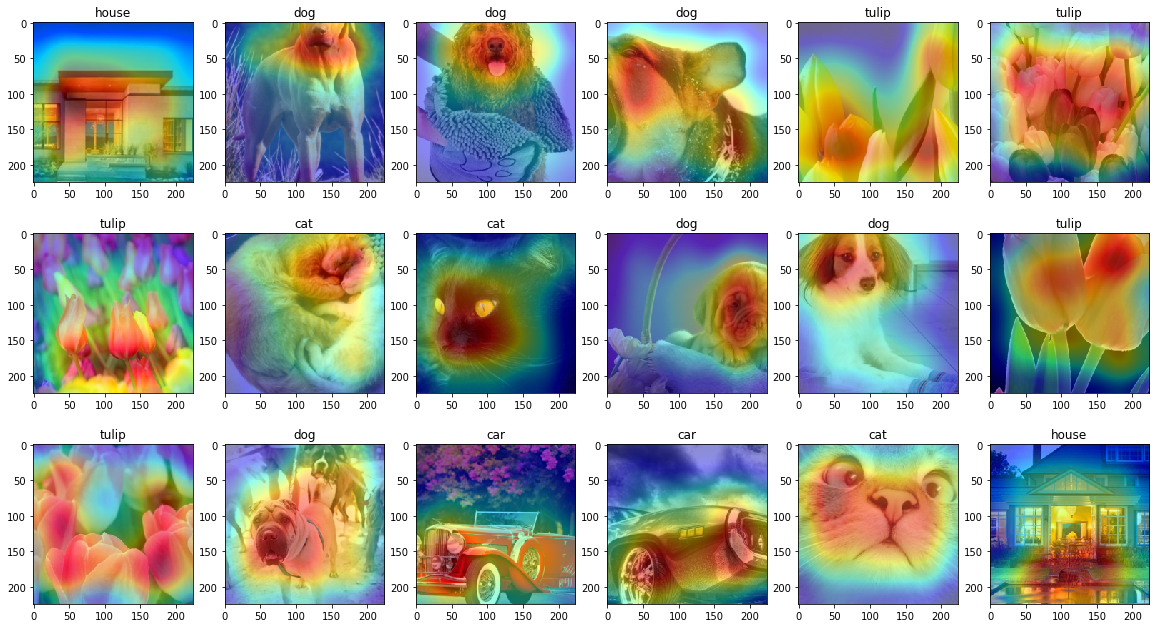

In [24]:
# load the model that got the best validation accuracy
path = os.path.join('models', 'model_densenet.pt')
densenet_transfer.load_state_dict(torch.load(path))

plot_cam(images[0:18].detach(), densenet_transfer, 
         datasets_dict['test'].classes, 
         model_name='densenet161', use_cuda=use_cuda)

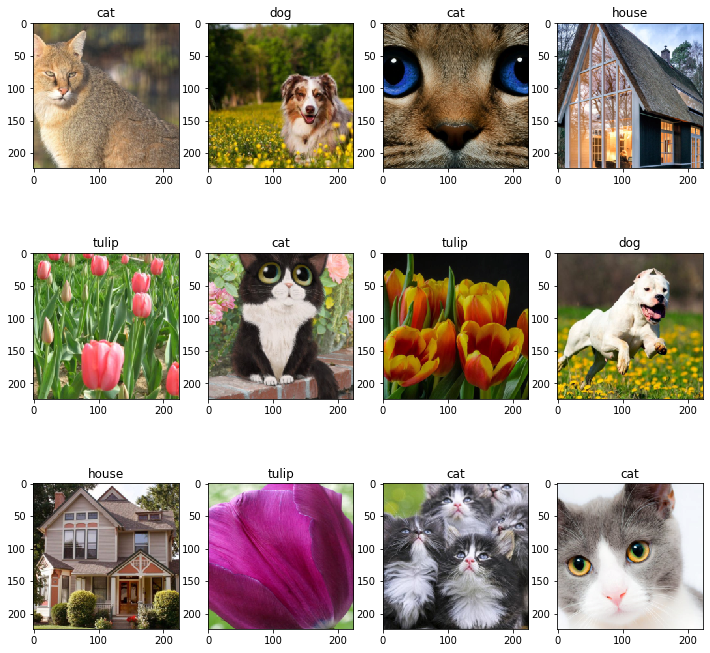

In [25]:
fig = plt.figure(figsize=(12, 12))
for i in range(12):
    class_name = datasets_dict['train'].classes[labels[i]]
    image = np.transpose(images[i].numpy(), axes=(1,2,0))
    # un-normalize
    image *= std
    image += mean
    image = np.clip(image, 0, 256)

    ax = fig.add_subplot(3, 4, i+1)
    ax.set_title(class_name, fontdict={'fontsize': 'large'})
    ax.imshow(image)
    
plt.show()